# Civilian Unemployment Rate Time Series

Using a different time series data set (either from FRED or elsewhere, go about the process of time series modeling. Specifically generate the following things:

- Plot the time series, along with any logical or necessary differences to get a stationary dataset
- Generate and interpret a PACF for the time series (and/or its differences)
- Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data
- Finally choose one specification and make the case for that as a logical model for your dataset.

I chose a dataset from the FRED database that describes the national civilian unemployment rate over time in the United States of America. Data was gathered monthly and recorded as a percent (seasonally adjusted).

In [51]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

from pandas import Series
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import pacf

from itertools import product
from statsmodels.tsa.arima_model import ARIMA

import math

Load and preview the data.

In [33]:
unrate = pd.read_csv('UNRATE.csv')
print(unrate.head())

         DATE  UNRATE
0  1948-01-01     3.4
1  1948-02-01     3.8
2  1948-03-01     4.0
3  1948-04-01     3.9
4  1948-05-01     3.5


Label columns, convert to numeric, set index, then plot.

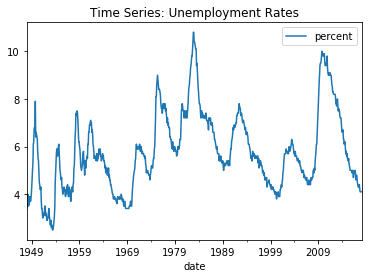

In [34]:
unrate.columns = ['date','percent']

pd.to_numeric(unrate['percent'], errors='coerce')
unrate.index = pd.to_datetime(unrate.date)

unrate.plot()
plt.title('Time Series: Unemployment Rates')
plt.show()

This data does not look obviously stationary, and appears to have evidence of seasonality. There is a slight general trend upwards but it may not be statistically significant. Let's calculate and plot the first order difference and observe stationarity in the transformed dataset.

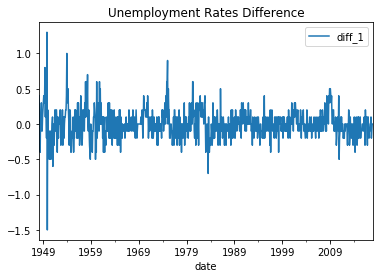

In [37]:
unrate['diff_1'] = unrate.percent - unrate.percent.shift()
# Alternate syntax: unrate['diff_1'] = unrate['percent'].diff(periods = 1)
unrate.plot(y='diff_1')
plt.title('Unemployment Rates Difference')
plt.show()

Despite the variance appearing very extreme at the beginning of the dataset, the plot looks staionary as it is centered around 0 and the variance is relatively consistent. To confirm, I will apply the ADFuller test.

In [35]:
X = unrate['percent'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.062588
p-value: 0.029449
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


The p-value for the initial time series is under 0.05, so we can conclude that the data does not have a unit root and is therefore stationary. However, we will also check the stationarity of the differenced series using the same ADFuller test. <br>

Source: https://machinelearningmastery.com/time-series-data-stationary-python/

In [38]:
X = unrate['diff_1'].dropna().values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.617011
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


The p-value for the first order differencing is even lower than the initial time series, so we can conclude that the data is stationary. We will plot the autocorrelation for both series below. 

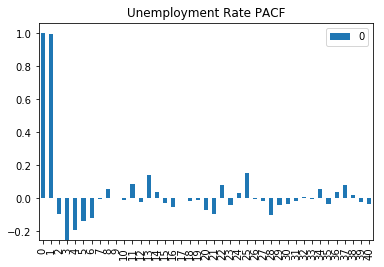

In [40]:
x_acf = pd.DataFrame(pacf(unrate.percent))
x_acf.plot(kind='bar')
plt.title("Unemployment Rate PACF")

For the initial time series, it looks like an order of 1 is the strongest. However, we see strong autocorrelation all the way up to 6. We will iterate through all numbers between 1-6 to input to the ARIMA model.

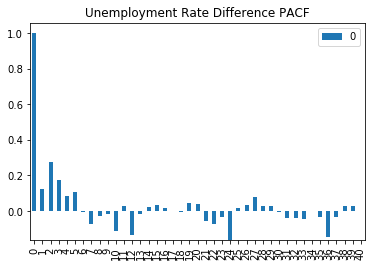

In [42]:
# NOTE: ignore the first element of differences because it's NaN,
# which will invalidate the rest of the plot.

x_acf = pd.DataFrame(pacf(unrate.diff_1[1:]))
x_acf.plot(kind='bar')
plt.title("Unemployment Rate Difference PACF")

This PACF plot reveals relatively high autocorrelation at an order of 2, with other high values ranging from 1-5. Although none of the values are as strong as the first value of the initial time series, the rest of the values are comparable and therefore we should iterate through all numbers between 1-5 to input to the ARIMA model.

In [49]:
results = []

p_all = (0, 1, 2, 3, 4, 5, 6)
d_all = (0, 1)
q_all = (0, 1, 2, 3, 4, 5)

for p,d,q in product(p_all, d_all, q_all):
    parameters = (p,d,q)
    print('Evaluating ', parameters)
    
    try:
        model = ARIMA(unrate.percent, order=parameters)
        model_fit = model.fit()
        #print(model_fit.summary())
        #print('Residuals Description')
        #print(model_fit.resid.describe())

        # Store the metrics we care about.
        results.append({
            'parameters': parameters,
            'stationary': True,
            'aic': model_fit.aic,
            'log_likelihood': model_fit.llf
        })
    except:
        pass
        
print('Done')

Evaluating  (0, 0, 0)
Evaluating  (0, 0, 1)
Evaluating  (0, 0, 2)
Evaluating  (0, 0, 3)
Evaluating  (0, 0, 4)
Evaluating  (0, 0, 5)
Evaluating  (0, 1, 0)
Evaluating  (0, 1, 1)
Evaluating  (0, 1, 2)
Evaluating  (0, 1, 3)
Evaluating  (0, 1, 4)
Evaluating  (0, 1, 5)
Evaluating  (1, 0, 0)
Evaluating  (1, 0, 1)
Evaluating  (1, 0, 2)
Evaluating  (1, 0, 3)
Evaluating  (1, 0, 4)
Evaluating  (1, 0, 5)
Evaluating  (1, 1, 0)
Evaluating  (1, 1, 1)
Evaluating  (1, 1, 2)
Evaluating  (1, 1, 3)
Evaluating  (1, 1, 4)
Evaluating  (1, 1, 5)
Evaluating  (2, 0, 0)
Evaluating  (2, 0, 1)
Evaluating  (2, 0, 2)
Evaluating  (2, 0, 3)
Evaluating  (2, 0, 4)
Evaluating  (2, 0, 5)
Evaluating  (2, 1, 0)
Evaluating  (2, 1, 1)
Evaluating  (2, 1, 2)
Evaluating  (2, 1, 3)
Evaluating  (2, 1, 4)
Evaluating  (2, 1, 5)
Evaluating  (3, 0, 0)
Evaluating  (3, 0, 1)
Evaluating  (3, 0, 2)
Evaluating  (3, 0, 3)
Evaluating  (3, 0, 4)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (3, 0, 5)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (3, 1, 0)
Evaluating  (3, 1, 1)
Evaluating  (3, 1, 2)
Evaluating  (3, 1, 3)
Evaluating  (3, 1, 4)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (3, 1, 5)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (4, 0, 0)
Evaluating  (4, 0, 1)
Evaluating  (4, 0, 2)
Evaluating  (4, 0, 3)
Evaluating  (4, 0, 4)


/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:492: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:493: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:493: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:494: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:495: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:495: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


Evaluating  (4, 0, 5)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (4, 1, 0)
Evaluating  (4, 1, 1)
Evaluating  (4, 1, 2)


/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:536: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:536: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:537: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:537: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Evaluating  (4, 1, 3)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (4, 1, 4)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (4, 1, 5)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (5, 0, 0)
Evaluating  (5, 0, 1)
Evaluating  (5, 0, 2)
Evaluating  (5, 0, 3)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (5, 0, 4)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (5, 0, 5)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (5, 1, 0)
Evaluating  (5, 1, 1)
Evaluating  (5, 1, 2)
Evaluating  (5, 1, 3)
Evaluating  (5, 1, 4)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (5, 1, 5)
Evaluating  (6, 0, 0)
Evaluating  (6, 0, 1)
Evaluating  (6, 0, 2)
Evaluating  (6, 0, 3)
Evaluating  (6, 0, 4)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (6, 0, 5)
Evaluating  (6, 1, 0)
Evaluating  (6, 1, 1)
Evaluating  (6, 1, 2)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (6, 1, 3)


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluating  (6, 1, 4)
Evaluating  (6, 1, 5)
Done


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


With or without the try/except thing, we get this ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can pass your own start_params.

what does this mean?

In [ ]:
Now that we have our results, we will rank them first by the lowest AIC value, and then by the lowest log_likelihood.

In [52]:
ranked_results = sorted(
    results,
    key=lambda r: (r['aic'], r['log_likelihood']))

min_aic = ranked_results[0]['aic']

for result in ranked_results:
    prob_best_params_are_better_than_current_params = (
        math.exp((min_aic - result['aic']) / 2)
    )
    print(
        result['parameters'],
        result['aic'],
        result['log_likelihood'],
        prob_best_params_are_better_than_current_params)

(4, 0, 5) -382.41310378960816 202.20655189480408 1.0
(3, 1, 5) -380.1603442246728 200.0801721123364 0.324204826470347
(3, 0, 5) -377.0613689453253 198.53068447266264 0.06884708300200122
(6, 1, 4) -375.80914477073793 199.90457238536897 0.03681022903827835
(3, 0, 4) -374.94381693806963 196.47190846903482 0.023881685144215854
(2, 1, 4) -372.79831761187506 194.39915880593753 0.008169128154282824
(4, 1, 4) -372.3979509699666 196.1989754849833 0.006687090449572266
(5, 0, 4) -365.6239323801069 193.81196619005345 0.0002260881241674089
(5, 0, 5) -364.9735246778073 194.48676233890365 0.00016332155736365305
(5, 1, 4) -363.2020430310463 192.60102151552314 6.735520472804338e-05
(6, 0, 4) -362.91446826564425 193.45723413282212 5.833444813638894e-05
(4, 1, 3) -362.8066142087405 190.40330710437024 5.527196221297536e-05
(4, 0, 2) -362.6102013143727 189.30510065718636 5.0101919480781865e-05
(4, 0, 3) -362.1238415062671 190.06192075313356 3.928643980851186e-05
(3, 0, 3) -361.6680222852892 188.83401114264

A parameter combination of (4, 0, 5) gives us the lowest AIC score. AIC is a measure of the degree of information contained in the model. Although a low AIC score is desirable, sometimes the model pertaining to the minimum score has suffered some information loss. Using a simple formula, we can calculate the probability that each model we tested lost less information than the minimum. We don't see any high probabilities here, so we will select (4,0,5) as the best parameter combination. The next closest model uses the parameters (3,1,5). Despite this model having a lower log-likelihood, there is only 0.324 probability that this model lost less information than the minimum-AIC model. Additionally, it is equally parsimonious, which gives it no advantage over the top-performing model. <br>

Based on the above results, I believe the best parameter set is (4,0,5). This means that 4 prior timepoints were used for the autoregressive component, the initial time series dataset without differencing was used, and 5 prior timepoints were used for the moving average component.